In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


from scipy import stats
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.metrics import f1_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,plot_tree
from sklearn import metrics

from xgboost import XGBClassifier, plot_tree
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

from statsmodels.formula.api import ols
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

import pickle
import sqlite3

### Importation CSV et création du dataframe

In [3]:
df = pd.read_csv("data.csv")
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56368,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
56369,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
56370,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
56371,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [110]:
df.drop_duplicates(inplace=True)

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45211 entries, 0 to 56372
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  deposit    45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 6.2+ MB


### Création de la matrice X (variables explicatives) et de la série y (variable cible)

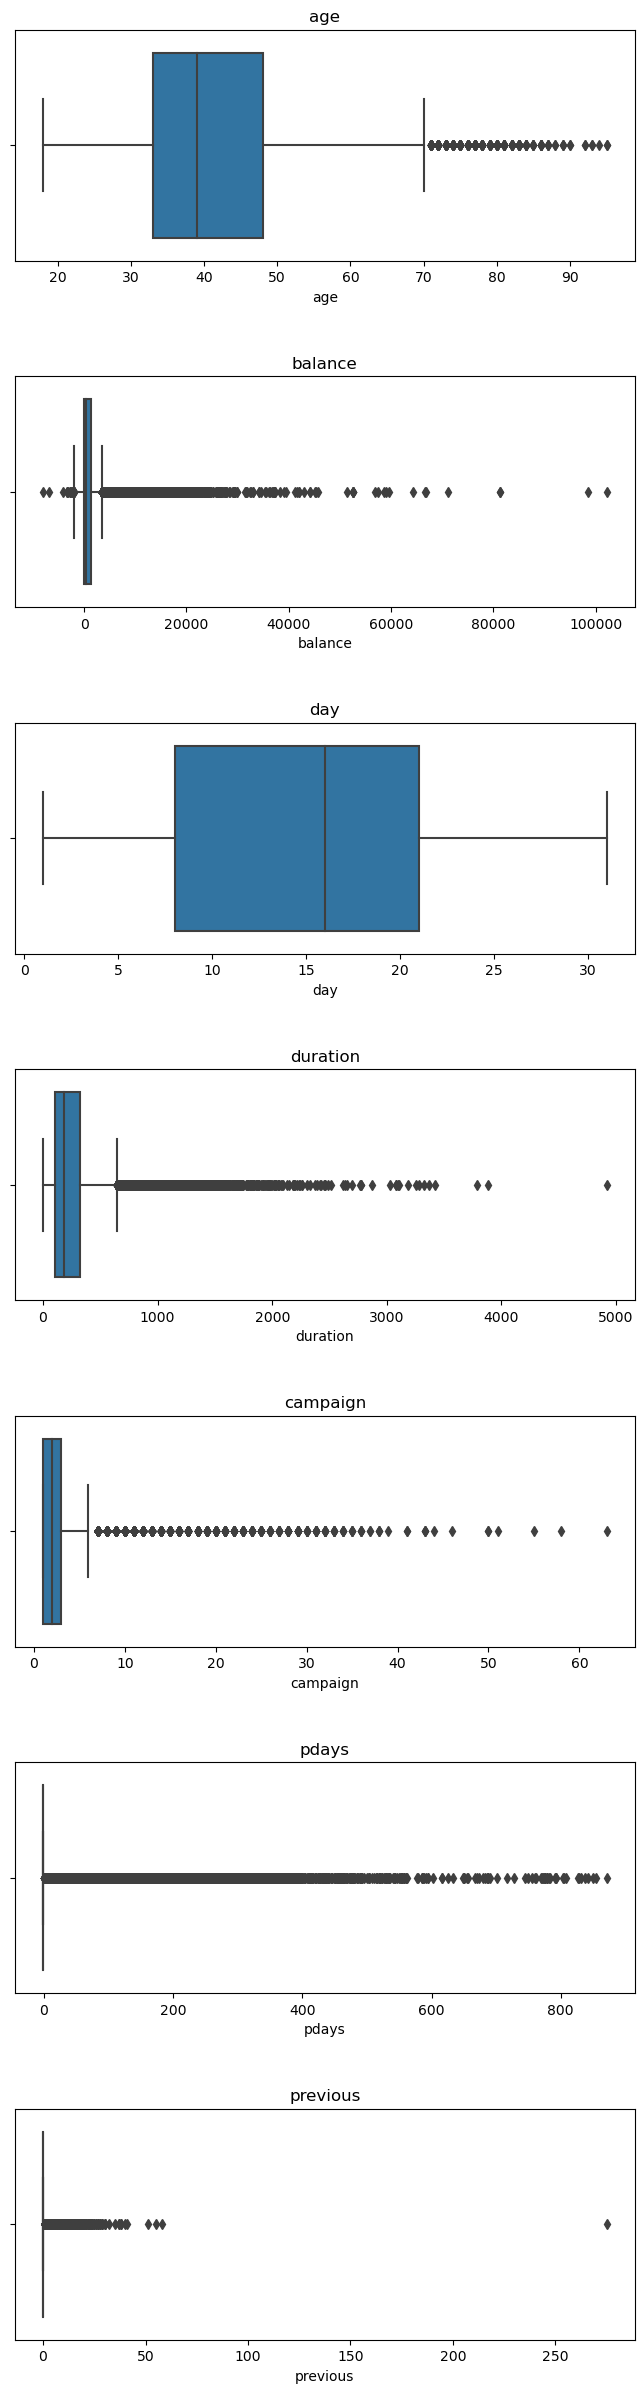

In [112]:
# Generate individual plot for the numerical variables, they are in different ranges

cols_num = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(8,30))
fig.subplots_adjust(hspace=0.5)

for i, col in enumerate(cols_num):
    sns.boxplot(x=col, data=df, ax=ax[i]) # "boxplot" can allow us to see the outliers points
    ax[i].set_title(col)

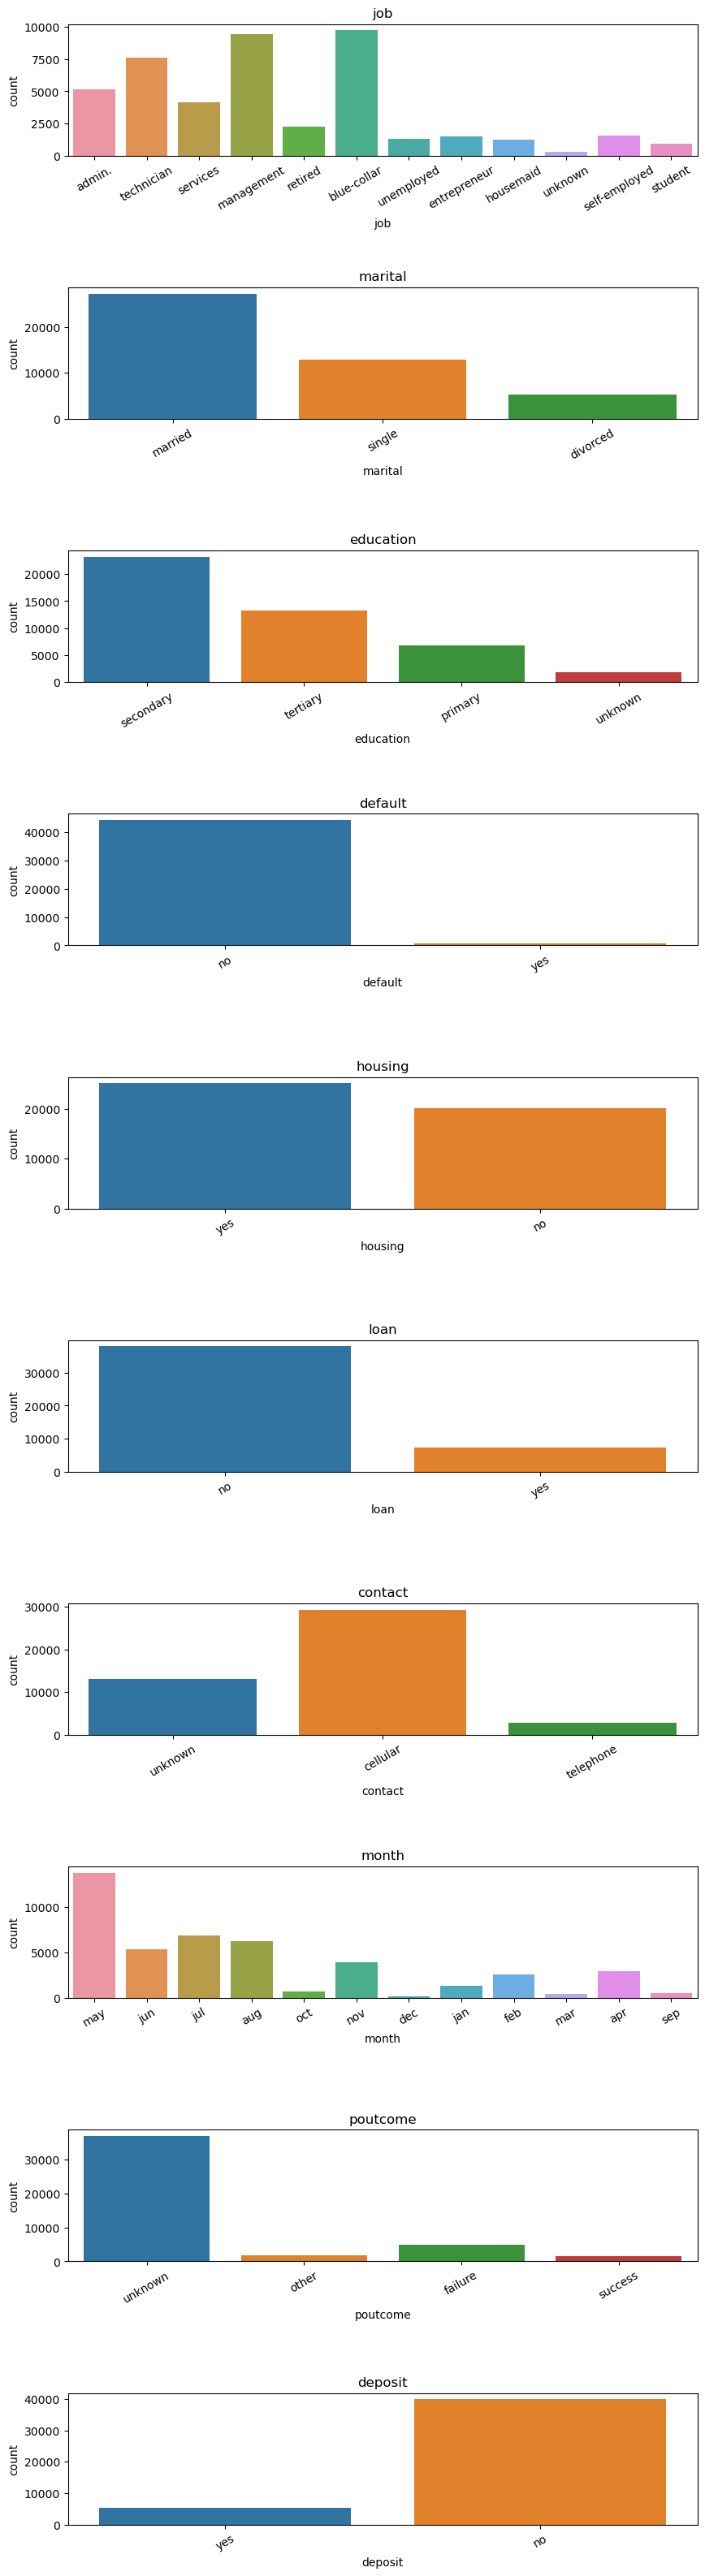

In [113]:
# Plots of sub-levels of each categorical's variables

cols_cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']

fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(10,40))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(cols_cat):
    sns.countplot(x=col, data=df, ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation=30)

In [5]:
# X = df.drop(['deposit','poutcome'], axis=1)
# y = df['deposit']

X = df.drop(['deposit','poutcome','contact','duration','previous','day','default'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.8, random_state=42, stratify=y)

# Score du dummy classifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)



0.8123281596452329

### Création d'un pipeline

In [115]:
transformer = make_column_transformer(
    (OneHotEncoder(),make_column_selector(dtype_exclude=np.number)),
    (StandardScaler(),make_column_selector(dtype_include=np.number))
    )

### Création d'un  RandomForest

In [116]:
forest= make_pipeline(
    transformer,
    RandomForestClassifier(
        max_depth=5,
        n_estimators=100,
        min_samples_leaf=1000,
        class_weight='balanced'
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
forest.fit(X_train,y_train)

#Utilisation d'un .features_importances_ pour déterminer quelle variable est importante pour la prédiction
A=forest.named_steps['randomforestclassifier'].feature_importances_

# #Score de notre modèle après la cross_validation
cross_val=cross_validate(forest, X_train, y_train,scoring='f1',cv=5)

cross_val['test_score'].mean()

/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    y : array-like of shape (n_samples,) or (n_samples, n_outputs) or None
  File "/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 220, in __call__
    estimator : object
  File "/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 268, in _score
    def set_score_request(self, **kwargs):
  File "/home/anas/miniconda3/envs/datascience_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1146, in f1_score
    Read more in the :ref:`User Guide <precision_reca

nan

In [117]:
# N, train_score, val_score = learning_curve(xgb, X_train, y_train,cv=5)
# print(N)
# plt.plot(N, train_score.mean(axis=1), label='train')
# plt.plot(N, pd.DataFrame(val_score).mean(axis=1), label='validation')
# plt.xlabel('train_sizes')
# plt.legend()

In [118]:
# y_pred=forest.predict(X_train)
# f1_score(y_train,y_pred)

In [119]:
A_columns=transformer.get_feature_names_out()
A_columns

array(['onehotencoder__job_admin.', 'onehotencoder__job_blue-collar',
       'onehotencoder__job_entrepreneur', 'onehotencoder__job_housemaid',
       'onehotencoder__job_management', 'onehotencoder__job_retired',
       'onehotencoder__job_self-employed', 'onehotencoder__job_services',
       'onehotencoder__job_student', 'onehotencoder__job_technician',
       'onehotencoder__job_unemployed', 'onehotencoder__job_unknown',
       'onehotencoder__marital_divorced',
       'onehotencoder__marital_married', 'onehotencoder__marital_single',
       'onehotencoder__education_primary',
       'onehotencoder__education_secondary',
       'onehotencoder__education_tertiary',
       'onehotencoder__education_unknown', 'onehotencoder__default_no',
       'onehotencoder__default_yes', 'onehotencoder__housing_no',
       'onehotencoder__housing_yes', 'onehotencoder__loan_no',
       'onehotencoder__loan_yes', 'onehotencoder__contact_cellular',
       'onehotencoder__contact_telephone',
       'one

In [120]:
df_coeff = pd.DataFrame([A_columns,A], index=['features', 'coeff']).T.explode('coeff')
df_coeff.sort_values(by='coeff', ascending=False).head(20)

,features,coeff
43,standardscaler__duration,0.426253
27,onehotencoder__contact_unknown,0.118567
21,onehotencoder__housing_no,0.073686
45,standardscaler__pdays,0.068334
22,onehotencoder__housing_yes,0.057012
25,onehotencoder__contact_cellular,0.052386
46,standardscaler__previous,0.04396
36,onehotencoder__month_may,0.03687
41,standardscaler__balance,0.024142
40,standardscaler__age,0.01756


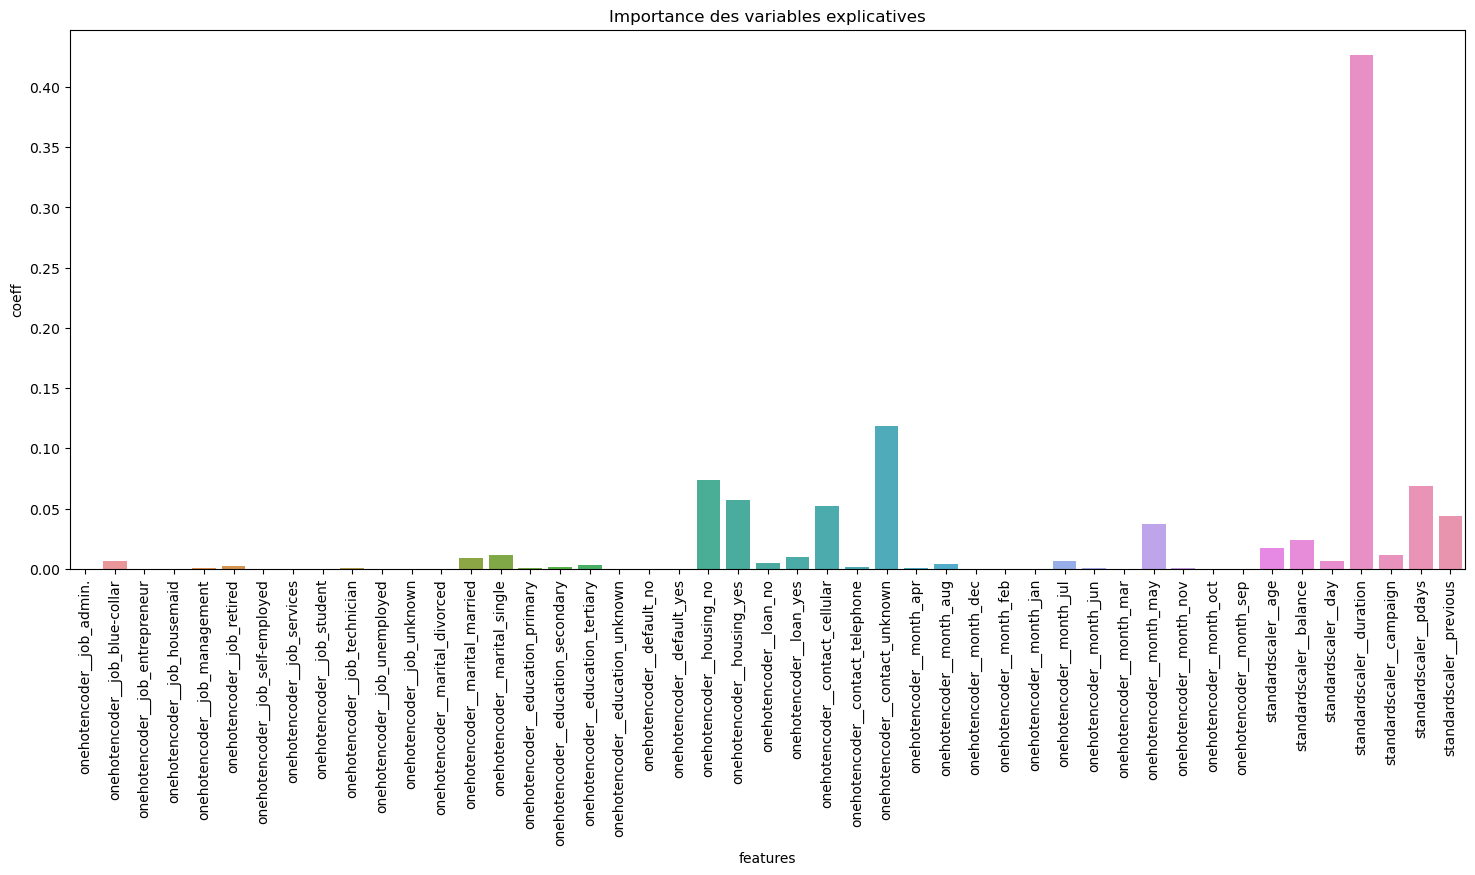

In [121]:
plt.figure(figsize=[18,7])
sns.barplot(data=df_coeff,x='features',y='coeff')
plt.xticks(rotation=90)
plt.title("Importance des variables explicatives")
plt.show()

In [122]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45211 entries, 0 to 56372
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.5+ MB


In [123]:
forest= make_pipeline(
    transformer,
    RandomForestClassifier(
        max_depth=10,
        n_estimators=100,
        min_samples_leaf=6000,
        min_samples_split=20000,
        max_leaf_nodes=15,
        class_weight='balanced'
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
forest.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x743c1d78e2b0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x743be650f2b0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_leaf_nodes=15,
                                        min_samples_leaf=6000,
                                        min_samples_split=20000))])

In [124]:
# y_pred=cross_val_predict(forest,X_train, y_train)

In [125]:
y_pred=cross_val_predict(forest,X_train, y_train)

In [126]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          no       0.88      0.80      0.84     31937
         yes       0.12      0.20      0.15      4231

    accuracy                           0.73     36168
   macro avg       0.50      0.50      0.49     36168
weighted avg       0.79      0.73      0.76     36168



In [127]:
cross_val=cross_validate(forest, X_train, y_train,scoring='f1_macro',cv=5)

cross_val['test_score'].mean()

0.32326989693439084

# Modele XGB pour projet final

In [273]:
conn = sqlite3.connect('/home/apprenant/Documents/projet_final/dossier_image_detection/entrainement.db')

# Exemple de requête SQL
query = "SELECT * FROM data;"

# Utilisation de pd.read_sql() pour lire les résultats de la requête dans un DataFrame
df = pd.read_sql(query, conn)


# Fermeture de la connexion à la base de données
conn.close()


In [274]:
df.drop_duplicates(inplace=True)
df.dropna()

,age,job,marital,education,defaut,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56356,59,management,married,tertiary,no,138,yes,yes,cellular,16,nov,162,2,187,5,failure,no
56360,37,management,married,tertiary,no,1428,no,no,cellular,16,nov,333,2,-1,0,unknown,no
56361,34,blue-collar,single,secondary,no,1475,yes,no,cellular,16,nov,1166,3,530,12,other,no
56371,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [275]:
X = df.drop(['deposit','poutcome','contact','duration','previous','day','defaut'], axis=1)
y = df['deposit']



In [276]:
X.reset_index(drop=True, inplace=True)

In [277]:
from imblearn.over_sampling import RandomOverSampler

# Créer une instance de RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Appliquer le sur-échantillonnage sur les données d'entraînement
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [278]:
def convert_labels(label):
    if label == 'no':
        return 0
    elif label == 'yes':
        return 1
    else:
        # Gérez le cas où la classe n'est ni 'no' ni 'yes', si nécessaire
        return None

# Appliquez la fonction de conversion aux étiquettes de classe
y= y.apply(convert_labels)


X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, train_size=0.8, random_state=42, stratify=y)
# Vérifiez à nouveau les classes uniques
classes_uniques = y_train.unique()
print(classes_uniques)


[0 1]


In [279]:
from imblearn.over_sampling import RandomOverSampler

# Créer une instance de RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Appliquer le sur-échantillonnage sur les données d'entraînement
X_train, y_train = oversampler.fit_resample(X_train, y_train)

In [280]:
transformer = make_column_transformer(
    (OneHotEncoder(),make_column_selector(dtype_exclude=np.number)),
    (StandardScaler(),make_column_selector(dtype_include=np.number))
    )

In [281]:
# transformer=make_column_transformer(
# (StandardScaler(), ['age','balance','campaign','pdays']),
# (OneHotEncoder(), ['job','marital','education','housing','loan','month']))

In [282]:
xgb= make_pipeline(
        transformer,
        XGBClassifier(
            max_depth=20,
            learning_rate=0.1,
            n_estimators=100,
            gamma=50, 
            min_child_weight=0,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.005
    )
)

# Entrainement de notre modèle en utilisant les paramètres par défaut 
xgb.fit(X_train,y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f69be9e8160>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f69be9e80d0>)])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None...
                               feature_types=None, gamma=50, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=20, max_leaves=None,
                               min_child_weight=0, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [283]:
xgb.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f69be9e8160>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f69be9e80d0>)])),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.8, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=50, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.1, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, ma

In [284]:
A=xgb.named_steps['xgbclassifier'].feature_importances_
A_columns=transformer.get_feature_names_out()
A_columns

array(['onehotencoder__job_admin.', 'onehotencoder__job_blue-collar',
       'onehotencoder__job_entrepreneur', 'onehotencoder__job_housemaid',
       'onehotencoder__job_management', 'onehotencoder__job_retired',
       'onehotencoder__job_self-employed', 'onehotencoder__job_services',
       'onehotencoder__job_student', 'onehotencoder__job_technician',
       'onehotencoder__job_unemployed', 'onehotencoder__job_unknown',
       'onehotencoder__marital_divorced',
       'onehotencoder__marital_married', 'onehotencoder__marital_single',
       'onehotencoder__education_primary',
       'onehotencoder__education_secondary',
       'onehotencoder__education_tertiary',
       'onehotencoder__education_unknown', 'onehotencoder__housing_no',
       'onehotencoder__housing_yes', 'onehotencoder__loan_no',
       'onehotencoder__loan_yes', 'onehotencoder__month_apr',
       'onehotencoder__month_aug', 'onehotencoder__month_dec',
       'onehotencoder__month_feb', 'onehotencoder__month_jan',
 

In [285]:
df_coeff = pd.DataFrame([A_columns,A], index=['features', 'coeff']).T.explode('coeff')
df_coeff.sort_values(by='coeff', ascending=False).head(20)

,features,coeff
19,onehotencoder__housing_no,0.133065
20,onehotencoder__housing_yes,0.105072
38,standardscaler__pdays,0.074164
23,onehotencoder__month_apr,0.064521
35,standardscaler__age,0.055871
14,onehotencoder__marital_single,0.045197
30,onehotencoder__month_mar,0.037763
36,standardscaler__balance,0.033251
33,onehotencoder__month_oct,0.032432
29,onehotencoder__month_jun,0.029456


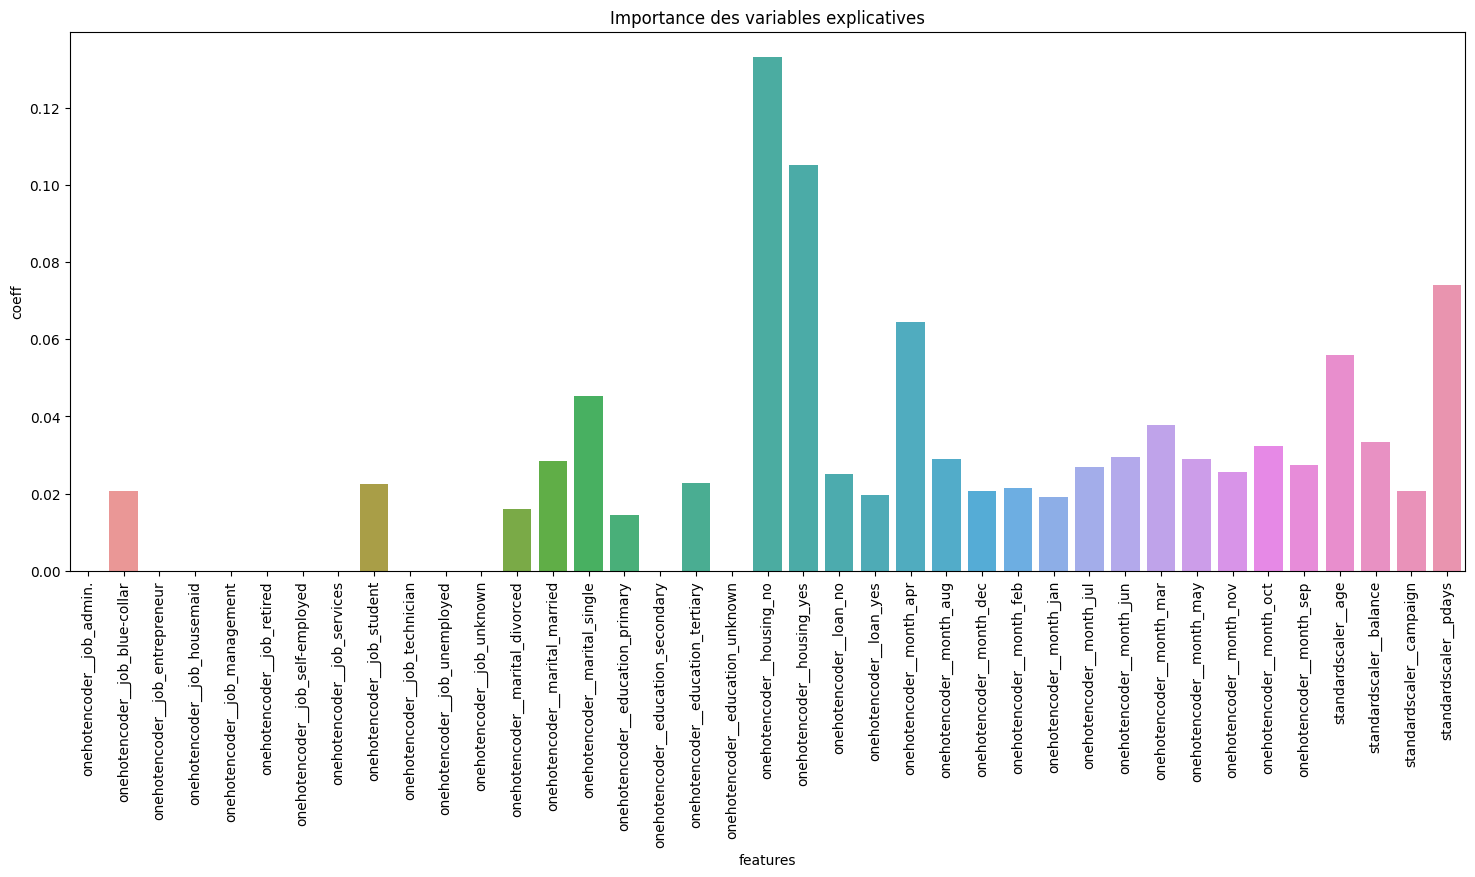

In [286]:
plt.figure(figsize=[18,7])
sns.barplot(data=df_coeff,x='features',y='coeff')
plt.xticks(rotation=90)
plt.title("Importance des variables explicatives")
plt.show()

In [287]:



# # Calculate correlation matrix
# correlation_matrix = X.corr()

# # Plot correlation heatmap
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('Correlation Heatmap')
# plt.show()


In [288]:
cross_val=cross_validate(xgb, X_train, y_train,scoring='f1_macro',cv=5)

cross_val['test_score'].mean()

0.7051059171895357

In [289]:
y_pred=xgb.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.84      0.75     31937
           1       0.79      0.59      0.68     31937

    accuracy                           0.72     63874
   macro avg       0.73      0.72      0.71     63874
weighted avg       0.73      0.72      0.71     63874



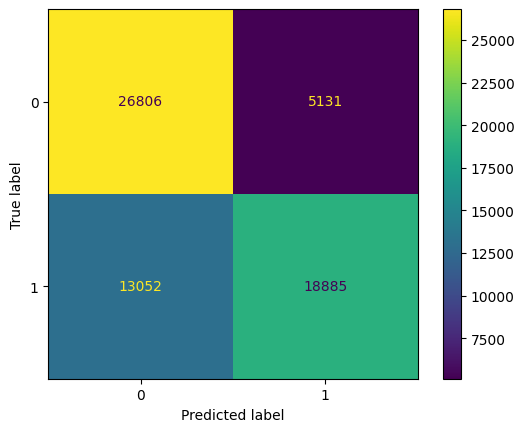

In [290]:
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Utilisation d'un RandomSearch pour obtenir une idée de l'ordre de grandeur des paramètres

In [292]:
#Pour trouver le nom des paramètres590599
xgb.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f69be9e8160>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f69be9e80d0>)])),
  ('xgbclassifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=0.8, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=50, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=0.1, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, ma

In [303]:
param_xgb = {'xgbclassifier__max_depth':np.arange(3,10,100),
              'xgbclassifier__min_child_weight':np.arange(1,10,100),
              'xgbclassifier__learning_rate':np.arange(0.01,0.3,100),
                'xgbclassifier__n_estimators':np.arange(50,1000,100),
                'xgbclassifier__gamma':np.arange(0,0.5,100),
                'xgbclassifier__reg_alpha':np.arange(0,1,100),
                'xgbclassifier__reg_lambda':np.arange(0,1,100)
                }
                
random_search = RandomizedSearchCV(xgb, param_distributions=param_xgb,scoring='f1', n_iter=1, cv=5, random_state=42)

random_search.fit(X_train, y_train)
print(random_search.best_params_)

{'xgbclassifier__reg_lambda': 0, 'xgbclassifier__reg_alpha': 0, 'xgbclassifier__n_estimators': 850, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__max_depth': 3, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__gamma': 0.0}


### Utilisation d'un GridSearch pour cibler les meilleurs paramètres

In [304]:
params = {'xgbclassifier__max_depth':np.arange(2,4,10),
              'xgbclassifier__min_child_weight':np.arange(0,1,10),
              'xgbclassifier__learning_rate':np.arange(0.005,0.15,100),
                'xgbclassifier__n_estimators':np.arange(800,900,100)
                }

grid=GridSearchCV(xgb, param_grid=params, scoring='f1', cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f69be9e8160>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f69be9e80d0>)])),
                                       ('xgbclassifier',
                                        X...
                                                      min_child_weight=0,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'xgbclassifier__learning_rate': array([0.005]),
                         'xgbclassifier__max_depth': array([2]),
                         'xgbclassifier__min_child_weight': array([0]),
                         'xgbclassifier__n_estimators': array([800])},
             scoring='f1')

In [305]:
grid.best_score_

0.6534843229781343

In [306]:
with open('xgb.pkl', 'wb') as file:
  pickle.dump(xgb, file)


In [307]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63874 entries, 0 to 63873
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        63874 non-null  int64 
 1   job        63874 non-null  object
 2   marital    63874 non-null  object
 3   education  63874 non-null  object
 4   balance    63874 non-null  int64 
 5   housing    63874 non-null  object
 6   loan       63874 non-null  object
 7   month      63874 non-null  object
 8   campaign   63874 non-null  int64 
 9   pdays      63874 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 4.9+ MB


In [308]:
B={
  "age" : 32,
  "housing": "yes",
  "marital": "married",
  "job": "admin.",
  "loan": "no",
  "balance": 0,
  "education": "secondary",
  "pdays": 187,
  "campaign": 1,
  "month": "may"
}

In [309]:
A= pd.DataFrame( B, index=[0])
A

,age,housing,marital,job,loan,balance,education,pdays,campaign,month
0,32,yes,married,admin.,no,0,secondary,187,1,may


In [310]:
xgb.predict(A)[0]

1